# Import Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from pandas.plotting import scatter_matrix
import sys

% matplotlib inline

print('Python version', sys.version)
print('Pandas version', pd.__version__)
print('Numpy version', np.__version__)

Python version 3.6.3 |Anaconda, Inc.| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas version 0.20.3
Numpy version 1.14.0


In [21]:
data = pd.read_pickle('../data/cleaned_data.pkl')

In [22]:
data.head()

,School_ID,Graduation_Rate_School,Short_Name,School_Type,Transportation_El,School_Latitude,School_Longitude,Average_ACT_School,crimes_per_student,dollars_per_student,percent_diff_budget,percent_low_income
0,609678,91.8,JONES HS,Selective enrollment,"Blue, Brown, Pink, Red",41.873066,-87.627675,26.2,0.041801,5928.036977,-0.020497,0.392283
1,400056,82.4,NOBLE - ROWE CLARK HS,Charter,"Blue, Brown, Green",41.895362,-87.718047,18.5,0.702532,9852.668776,0.011480,0.930380
2,610244,85.8,CLARK HS,Magnet,"Blue, Green",41.872885,-87.753325,16.3,0.122263,8522.198905,0.011480,0.934307
3,400058,67.1,NORTH LAWNDALE - CHRISTIANA HS,Charter,Green,41.858564,-87.708987,15.3,0.641457,5184.064426,-0.181877,0.977591
4,400059,69.7,NORTH LAWNDALE - COLLINS HS,Charter,Red,41.864146,-87.700681,14.5,0.150997,5272.680912,-0.181877,0.968661


# EDA

## Investigating School Type

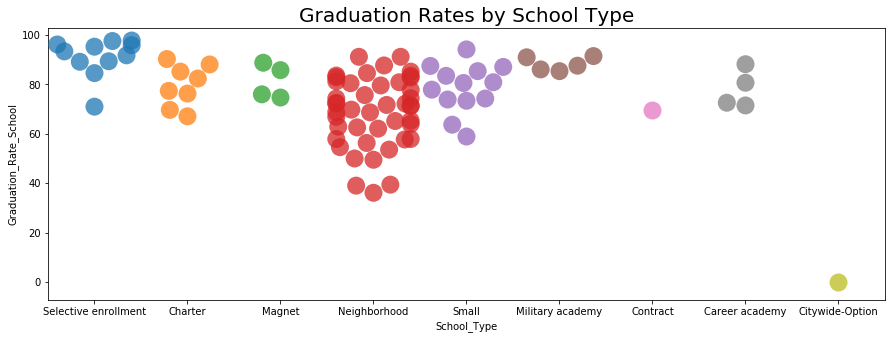

In [44]:
fig, ax = plt.subplots(figsize=(15,5))

sns.swarmplot(x="School_Type", y="Graduation_Rate_School", 
              data=data, size=18, alpha=.75);
ax.set_title('Graduation Rates by School Type', size=20);


A couple observations about the plot above:
> **1)** The school type **Selective Enrollment** seems to be characterized by a high graduation rate (with one exception), but other types seem to fall across a broader spectrum of graduation rates

> **2)** There also seems to be an outlier we don't need - the single **Citywide-Option** school type that has a graduation rate of 0

### 1) Add Selective Enrollment Variable
Let's create a new variable to indicate if the school is a Selective Enrollment School instead of blowing out our feature matrix with dummy variables for all school types

In [49]:
data['is_selective_enroll'] = [1 if x == 'Selective enrollment' else 0 for x in data['School_Type']]

### 2) Remove Graduation Rate Outlier
We should also drop the row in our dataset that has a 0% graduation rate... that doesn't seem right

In [52]:
data.sort_values(by='Graduation_Rate_School').head(3)

,School_ID,Graduation_Rate_School,Short_Name,School_Type,Transportation_El,School_Latitude,School_Longitude,Average_ACT_School,crimes_per_student,dollars_per_student,percent_diff_budget,percent_low_income,is_selective_enroll
81,610557,0.0,PATHWAYS - ASHBURN HS,Citywide-Option,NaN,41.735239,-87.704060,15.1,0.154185,16307.753304,0.029949,0.881057,0
29,609712,36.1,HIRSCH HS,Neighborhood,"Blue, Green",41.753748,-87.601727,13.1,0.704545,14613.939394,0.069544,0.901515,0
5,610389,39.0,ORR HS,Neighborhood,NaN,41.894449,-87.726166,14.2,0.721014,13416.021739,0.089964,0.952899,0


In [59]:
bad_index = data.sort_values(by='Graduation_Rate_School').head(1).index

In [60]:
data.drop(data.index[bad_index], inplace=True)
data.sort_values(by='Graduation_Rate_School').head(3)

,School_ID,Graduation_Rate_School,Short_Name,School_Type,Transportation_El,School_Latitude,School_Longitude,Average_ACT_School,crimes_per_student,dollars_per_student,percent_diff_budget,percent_low_income,is_selective_enroll
29,609712,36.1,HIRSCH HS,Neighborhood,"Blue, Green",41.753748,-87.601727,13.1,0.704545,14613.939394,0.069544,0.901515,0
5,610389,39.0,ORR HS,Neighborhood,NaN,41.894449,-87.726166,14.2,0.721014,13416.021739,0.089964,0.952899,0
30,609707,39.4,ROBESON HS,Neighborhood,"Brown, Red",41.769714,-87.637153,13.2,0.731707,15694.008130,0.057222,0.959350,0


## Visualize Correlation

In [146]:
target_features = data.loc[:,['Graduation_Rate_School', 'Average_ACT_School', 'crimes_per_student', 
                              'dollars_per_student', 'percent_diff_budget', 'percent_low_income', 'is_selective_enroll']]

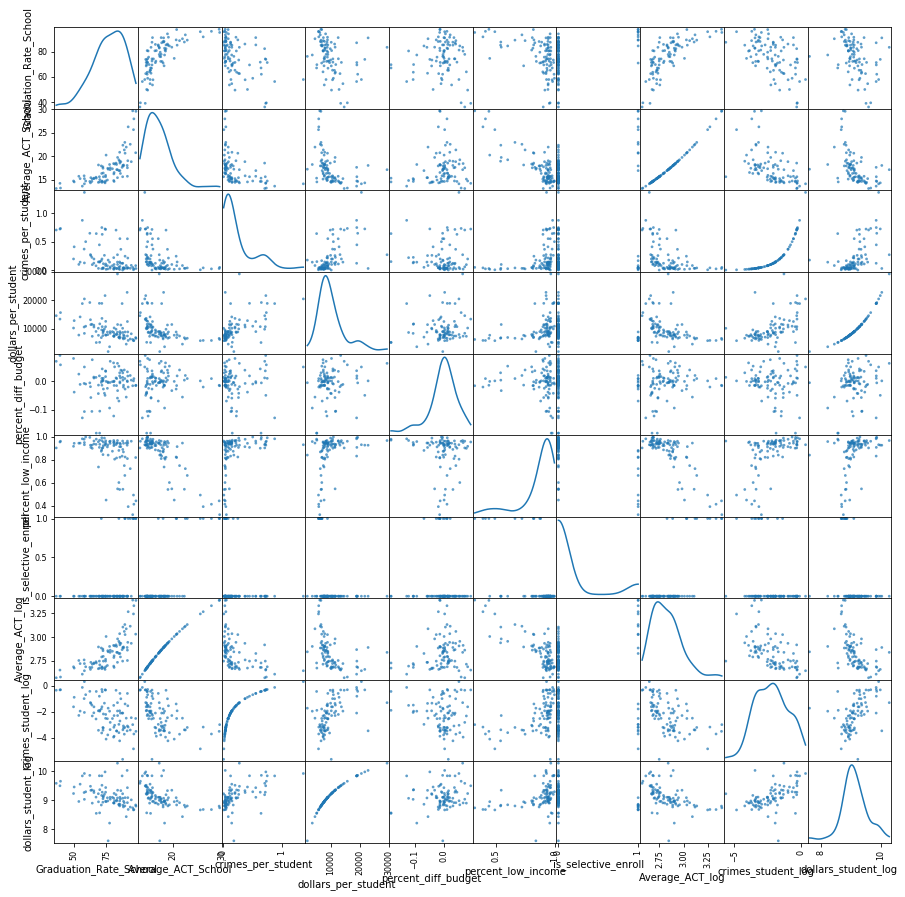

In [152]:
scatter_matrix(target_features, alpha=0.7, s=30, figsize=(15, 15), diagonal='kde');

Ok, so I'm going to take the log of:

- **Average ACT**

- **Crimes per Student**

- **Dollars per Student**

It looks like the **Percent Diff Budget** and **Percent Low Income** aren't very correlated to my target but maybe this will change after the data is on the same scale?

## Feature Transformation

Let's try exponentially transforming our **Average ACT**, **Crimes per Student**, **Dollars per Student** feature to capture more of the curve

In [150]:
target_features['Average_ACT_log'] = target_features["Average_ACT_School"].apply(np.log)
target_features['crimes_student_log'] = target_features["crimes_per_student"].apply(np.log)
target_features['dollars_student_log'] = target_features["dollars_per_student"].apply(np.log)

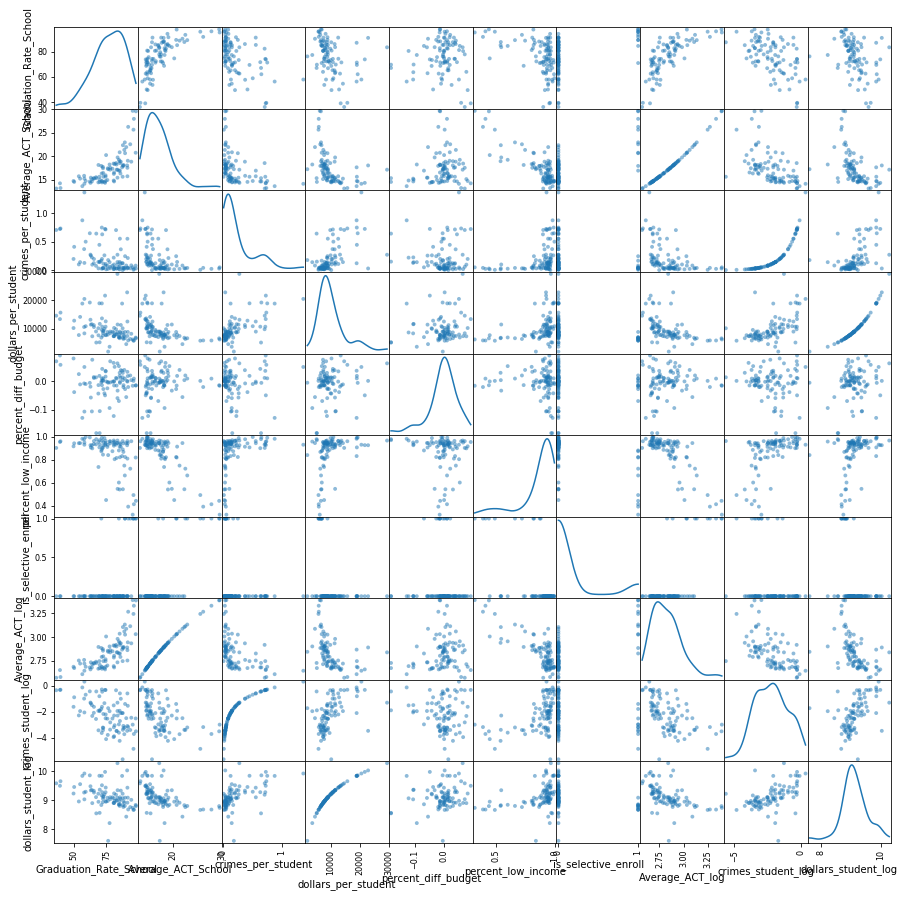

In [151]:
scatter_matrix(target_features, alpha=0.5, s=60, figsize=(15, 15), diagonal='kde');

# Cross Validation

In [154]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()

In [155]:
class Stats:
    
    def __init__(self, X, y, model):
        self.data = X
        self.target = y
        self.model = model
        ## degrees of freedom population dep. variable variance
        self._dft = X.shape[0] - 1   
        ## degrees of freedom population error variance
        self._dfe = X.shape[0] - X.shape[1] - 1  
    
    def sse(self):
        '''returns sum of squared errors (model vs actual)'''
        squared_errors = (self.target - self.model.predict(self.data)) ** 2
        return np.sum(squared_errors)
        
    def sst(self):
        '''returns total sum of squared errors (actual vs avg(actual))'''
        avg_y = np.mean(self.target)
        squared_errors = (self.target - avg_y) ** 2
        return np.sum(squared_errors)
    
    def r_squared(self):
        '''returns calculated value of r^2'''
        return 1 - self.sse()/self.sst()
    
    def adj_r_squared(self):
        '''returns calculated value of adjusted r^2'''
        return 1 - (self.sse()/self._dfe) / (self.sst()/self._dft)

In [156]:
def pretty_print_stats(stats_obj):
    '''returns report of statistics for a given model object'''
    items = ( ('sse:', stats_obj.sse()), ('sst:', stats_obj.sst()), 
             ('r^2:', stats_obj.r_squared()), ('adj_r^2:', stats_obj.adj_r_squared()) )
    for item in items:
        print('{0:8} {1:.4f}'.format(item[0], item[1]))


In [165]:
X = target_features.loc[:, ['Average_ACT_log', 'crimes_student_log', 'dollars_student_log', 'is_selective_enroll']]
y = target_features.loc[:, 'Graduation_Rate_School']

In [166]:
linear.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [167]:
s1 = Stats(X, y, linear)
pretty_print_stats(s1)

sse:     7085.7118
sst:     16579.3690
r^2:     0.5726
adj_r^2: 0.5525


In [ ]:
def plot_residuals(x, y):

    x_reshape = x.reshape(-1,1)
